In [4]:
# The following allows multiple outputs in a single output cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Unsupervised learning problems consists of learning values or labels for unlabeled data.  There is no criterion measure available:  No Y, just X's.  

Most methods used for this type of ML problem are referred to as "clustering" algorithms. These are methods that attempt to partition cases into some finite number of categories.  The category labels are nominal data(i.e., unordered categories). The groups defined by clustering may be understood by describing their features, comparing clusters to each other, or by predicting cluster membership.

In a sense, clustering can be seen as a very extreme missing data problem.  All the labels data is missing, and the goal is to guess what they are. At the core of this the challenge of deciding how many clusters there are in a data set.

### Basic Types of Clustering

Most frequently used methods fall into one of the following categories:

* Hierarchical clustering
* Partitioning
* Model based  

_Hierarchical_ methods can be _agglomerative_ or _divisive_.  In the case of the former, when the clustering algorithm begins, observations are each in their own cluster.  As the algorithm proceeds, observations are joined to others using a _linkage_ rule.  In _divisive_ hierarchical clustering, observations start in one big cluster, and they are split off until all observations are separate.  Note that when using either of these approaches, a decision must be made about the actual number of clusters.

_Partitioning_ methods attempt to put observations into clusters based on proximities to a centroid measure like a vector of means or medians, while optimizing an objective like minimizing within-cluster variation.  In these methods, the number of clusters is provided a priori to the algorithm.  

_Model based_ methods work by assuming a statistical distribution approximates the data.  The distribution might be, for example, the multivariate Gaussian. Models of this type are often referred to as _finite mixture_ methods.  A version of the so-called [expectation maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) is applied to estimate the probabilities of each observation belonging to one of a finite number of groups with it's own separate probability density.  This algorithm was originally described as a method for imputing missing data. 

Another, more recent, model-based approach is clustering using a [copula](https://en.wikipedia.org/wiki/Copula_(probability_theory).  A copula is a multivariate distribution that has uniform distributions on it's margins such that variables it describes can have different distributions, e.g., Gaussian, Poisson, and negative binomial.  Common forms of copulas include Gaussian and elliptical.  [Mixtures of copulas] have been used to cluster data where clusters consist of observations defined by a copula on the variables that are the basis for clustering. 

### K-Means Clustering Exercise

We're going to use the patient satisfaction data again, here.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [6]:
%matplotlib inline

In [7]:
patSatData=pd.read_csv('DECART-patSat.csv')

Here's what the variables are:  

| var name | item                 | rating scale  |
| :--------| :--------------------| :-------------|
| caseID   | respondent number    |  NA
|   sat    | overall satisfaction | 1 = very dissat, 10 = very sat
|   q2     | nurses listened      | 1 = never, 10 = always
|   q3     | nurses explained     | 1 = never, 10 = always
|   q4     | staff courteous      | 1 = never, 10 = always
|   q5     | meals appetizing     | 1 = never, 10 = always
|   q6     | doctors listened     | 1 = never, 10 = always
|   q7     | doctors explained    | 1 = never, 10 = always
|   q8     | staff responsive     | 1 = not at all, 10 = extremely
|   q9     | room was comfortable | 1 = not at all, 10 = extremely
| ptCat    | patient category     | 1= surg, 1 = med, 2 = concierge


`scikit-learn` has some convenient clustering tools.

In [8]:
from sklearn.cluster import KMeans

In [9]:
# select some variables, and convert to an np array:
clustVars=patSatData.columns[2:10]
patX=patSatData.loc[:,clustVars].values
type(patX)
patX.shape
X=patX

numpy.ndarray

(1811, 8)

In [10]:
#Three cluster solution:

KM3=KMeans(n_clusters=3,random_state=0)

In [11]:
KM3labs=KM3.fit_predict(X)  # cluster labels

In [12]:
pd.Series(KM3labs).value_counts()  # the number of cases in each cluster

2    780
1    579
0    452
dtype: int64

**EXERCISE** Get two cluster and three cluster solutions in the same way that the three cluster solution was obtained, above.

So, how "good" is this solution?  It turns out that here many different metrics that can inform about cluster solution "quality," e.g. on [cluster metrics on scikit-learn.org](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).  An online search will result in a lot of content on the topic.   For example, you can find information about Tibshirani, Walther and Hastie's [Gap Statistic](https://web.stanford.edu/~hastie/Papers/gap.pdf), as well as some Python implementations of it.  Other common practices include plotting the within cluster sums of squares as a function of the number of clusters, and picking the number corresponding to an "elbow" in the curve.  Like looking for the kink in a scree plot for principal components analysis results, an "elbow" may not be so obvious.

Generally speaking, quality measures are of two types, those that compare a solution to "truth," which require knowing what the _real_ cluster memberships are, and those that have to do with the result per se, e.g. being about the tightness and separate of clusters.

One of the cluster quality metrics `scikit-learn` provides for use with the "truth" isn't known is the [Calinski-Harabaz index](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabaz_score.html#sklearn.metrics.calinski_harabaz_score), which measures the ratio of within cluster variation to the variation between clusters.  The larger the better for this one.  Let's see what it says about our three cluster solution:

In [50]:
from sklearn.metrics import calinski_harabaz_score
print('{:8.3f}'.format(calinski_harabaz_score(X, KM3labs)))

 884.733


The nature of a clustering solution could in principle be understood if it spans just a couple of dimensions, and if the shapes of the clusters in this space are relatively simple, e.g. hyper-elliptical versus stretched and distorted toroids.  

It turns out that there is a useful way of visually examining cluster solutions.  It consist of plotting a solution's [silhouette scores](https://en.wikipedia.org/wiki/Silhouette_(clustering).  

Luckily, `scikit-learn` can compute these scores, and we can plot them. These scores are measures of how well observations are assigned to the clusters they end up in. Score values fall in `[-1,1`], with 1 meaning that an observation 

In [14]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [15]:
KM3sil_score=silhouette_score(X, KM3labs, metric='euclidean')  # This is the overall average
print('{:6.3f}'.format(KM3sil_score))

 0.237


`silhouette_samples` returns the score for each observation:

In [16]:
KM3sil_samps=silhouette_samples(X,KM3labs)

In [17]:
silLabels=pd.DataFrame({'score':KM3sil_samps,'label':KM3labs})

In [59]:
silLabels.groupby(silLabels.label).describe()

score                                                              \
       count      mean       std       min       25%       50%       75%   
label                                                                      
0      452.0  0.178393  0.129224 -0.067509  0.064449  0.180259  0.291649   
1      579.0  0.428612  0.146009  0.062250  0.327661  0.457314  0.563074   
2      780.0  0.129245  0.118329 -0.178240  0.054977  0.136930  0.223170   

                 
            max  
label            
0      0.394403  
1      0.600311  
2      0.360825

Negative values suggest some observations are poorly assigned to the clusters they are in. Let's graph the scores to get a better look.

Some borrowed code from:  

(http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

the array X of predictor, or "basis" variables, is presumed to exist.  The list range_n_clusters specifies the dimensionalities of the cluster solutions to be plotted.

(-0.1, 1)

(0, 1841)

For n_clusters = 2 The average silhouette_score is : 0.33314345153373115


Text(-0.05,421,'0')

Text(-0.05,1336.5,'1')

Text(0.5,1,'The silhouette plot for the various clusters.')

Text(0.5,0,'The silhouette coefficient values')

Text(0,0.5,'Cluster label')

[]

Text(0.5,1,'The visualization of the clustered data.')

Text(0.5,0,'Feature space for the 1st feature')

Text(0,0.5,'Feature space for the 2nd feature')

Text(0.5,0.98,'Silhouette analysis for KMeans clustering on sample data with n_clusters = 2')

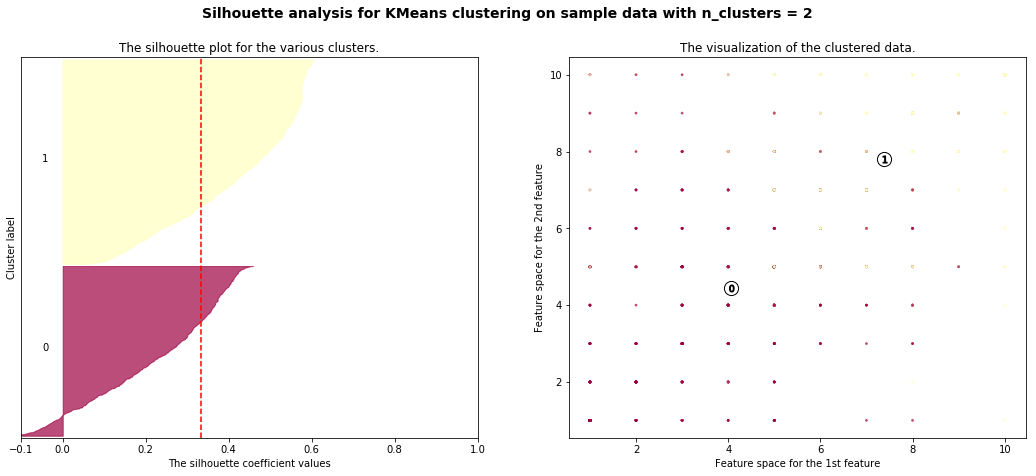

(-0.1, 1)

(0, 1851)

For n_clusters = 3 The average silhouette_score is : 0.23722292145387786


Text(-0.05,299.5,'0')

Text(-0.05,989,'1')

Text(-0.05,1615,'2')

Text(0.5,1,'The silhouette plot for the various clusters.')

Text(0.5,0,'The silhouette coefficient values')

Text(0,0.5,'Cluster label')

[]

Text(0.5,1,'The visualization of the clustered data.')

Text(0.5,0,'Feature space for the 1st feature')

Text(0,0.5,'Feature space for the 2nd feature')

Text(0.5,0.98,'Silhouette analysis for KMeans clustering on sample data with n_clusters = 3')

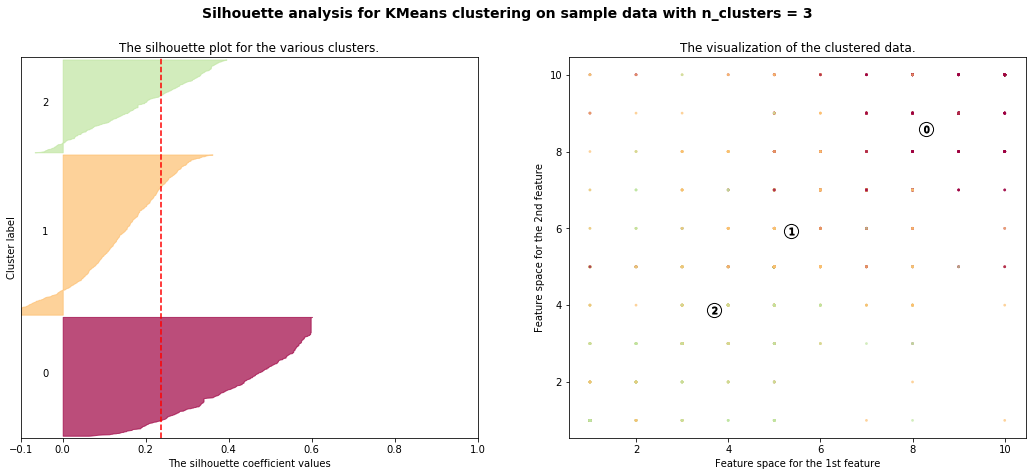

(-0.1, 1)

(0, 1861)

For n_clusters = 4 The average silhouette_score is : 0.2235064259740146


Text(-0.05,268.5,'0')

Text(-0.05,728,'1')

Text(-0.05,1207.5,'2')

Text(-0.05,1673.5,'3')

Text(0.5,1,'The silhouette plot for the various clusters.')

Text(0.5,0,'The silhouette coefficient values')

Text(0,0.5,'Cluster label')

[]

Text(0.5,1,'The visualization of the clustered data.')

Text(0.5,0,'Feature space for the 1st feature')

Text(0,0.5,'Feature space for the 2nd feature')

Text(0.5,0.98,'Silhouette analysis for KMeans clustering on sample data with n_clusters = 4')

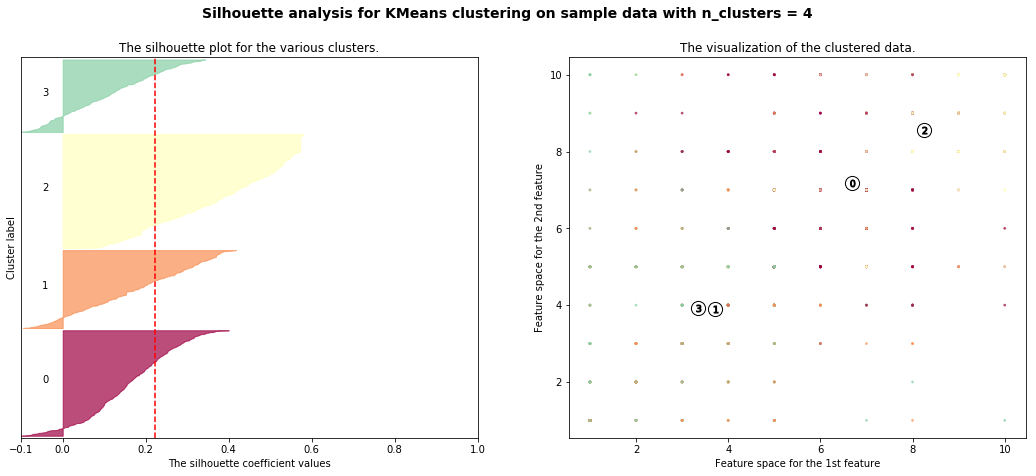

(-0.1, 1)

(0, 1871)

For n_clusters = 5 The average silhouette_score is : 0.19971482009322736


Text(-0.05,214.5,'0')

Text(-0.05,530.5,'1')

Text(-0.05,813,'2')

Text(-0.05,1152,'3')

Text(-0.05,1590.5,'4')

Text(0.5,1,'The silhouette plot for the various clusters.')

Text(0.5,0,'The silhouette coefficient values')

Text(0,0.5,'Cluster label')

[]

Text(0.5,1,'The visualization of the clustered data.')

Text(0.5,0,'Feature space for the 1st feature')

Text(0,0.5,'Feature space for the 2nd feature')

Text(0.5,0.98,'Silhouette analysis for KMeans clustering on sample data with n_clusters = 5')

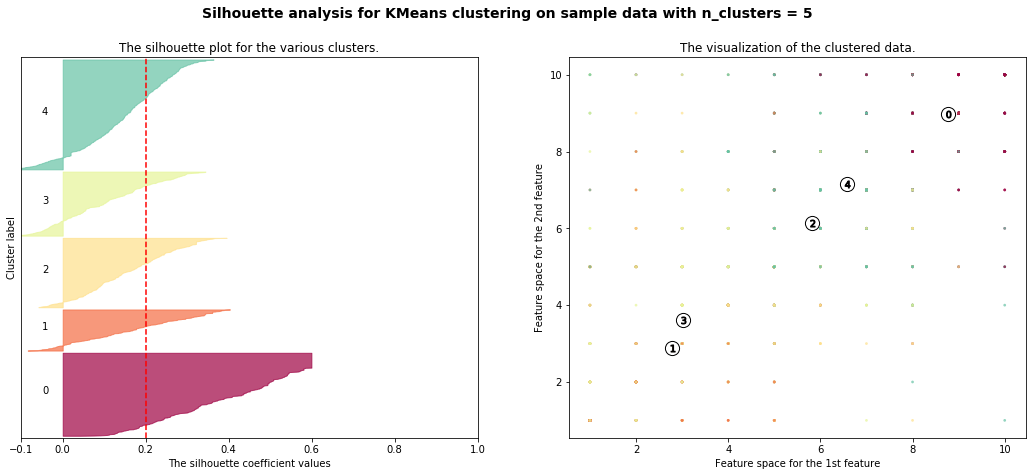

In [42]:
# Some borrowed code from scikit-learn:
range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

Note that silhouette scores can be used to assess the results of any clustering, not just those from KMeans.

### Hierarchical Clustering

Let's cluster the same data using an agglomerative hierarchical clustering method. 

In [43]:
from sklearn.cluster import AgglomerativeClustering as AgClust

In [67]:
hiClust3=AgClust(n_clusters=3)
hiClust3Mod=hiClust3.fit(X)
hi3Labs=hiClust3.fit_predict(X)
hi3Labs.shape

(1811,)

The linkage rule used here is "Ward's." Others available are "complete" and "average."  For documentation see [Agglomerative Clustering with scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

Let's take a look at a couple of metrics:

In [55]:
print('{:8.3f}'.format(calinski_harabaz_score(X, hi3Labs)))

 686.045


In [58]:
KM3sil_score=silhouette_score(X, hi3Labs, metric='euclidean')
print('{:6.3f}'.format(KM3sil_score))

 0.169


In [ ]:
We can take a look at the dendrogram for this:

In [60]:
from scipy.cluster.hierarchy import dendrogram

Here's where you can find the doc on [scipy dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

In [65]:
# Scooped from on Gitub...
# Authors: Mathew Kallada
# License: BSD 3 clause

#=========================================
#Plot Hierarachical Clustering Dendrogram 
#=========================================
#
#This example plots the corresponding dendrogram of a hierarchical clustering
#using AgglomerativeClustering and the dendrogram method available in scipy

#import numpy as np

#from matplotlib import pyplot as plt
#from scipy.cluster.hierarchy import dendrogram
#from sklearn.datasets import load_iris
#from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


#iris = load_iris()
#x = iris.data[:20]
#model = AgglomerativeClustering(n_clusters=3)

#model = model.fit(x)
#plt.title('Hierarchical Clustering Dendrogram')
#plot_dendrogram(model, labels=model.labels_)
#plt.show()


Text(0.5,1,'Hierarchical Clustering Dendrogram')

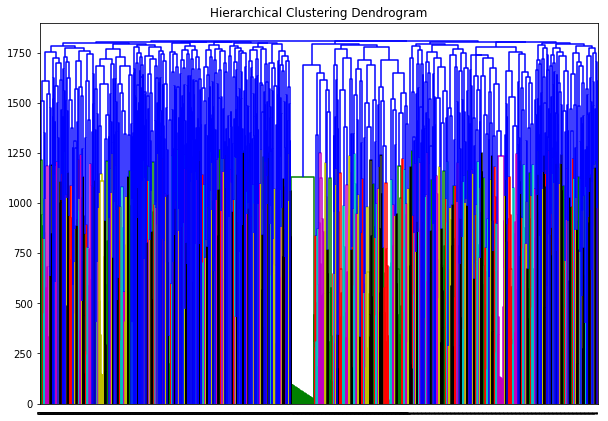

In [82]:
plt.rcParams['figure.figsize']=[10,7]
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(hiClust3Mod, labels=hi3Labs)
plt.show()

**EXERCISE**  This dendrogram is rather hard to look at. How would you make it easier to read?  Matplotlib "adjustments," or maybe something with `dendrogram`?  try the following.  It can be challenging to construct a visually useful dendrogram when you have many observations. The `seaborn` and `plotly` packages may be a little easier to use for dendrograms.

Text(0.5,1,'Hierarchical Clustering Dendrogram')

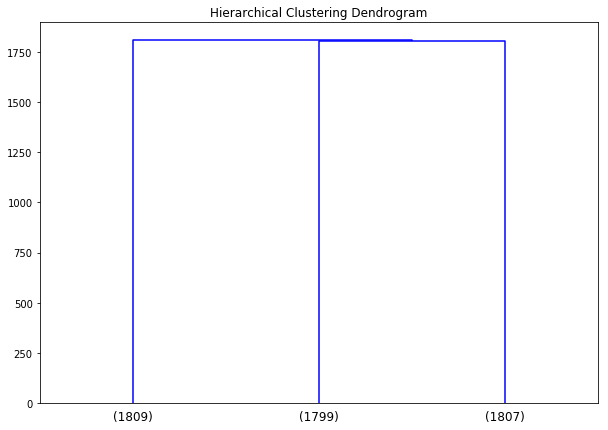

In [91]:
# The truncate_mode kwarg indicates cutting off at a specific number of clusters
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(hiClust3Mod, labels=hi3Labs,truncate_mode='lastp',p=3)
plt.show()

### Distance and Similarity

Up to this point we've been assuming when clustering that the distances between observations are Euclidean distances, like:

\begin{align*}
\large{
D(x_i,x_j)=\Bigg( \sum_{l=1}^{d}{{|x_{il}-x_{jl}} |}^2 \Bigg )^{1/2}
}
\end{align*}

where "d" is the number of dimensions.

Other distance metrics are defined by what have been called 
"Minkowki r metrics". The Euclidean distance measure is a particular r metric.  r metrics are defined as:

\begin{align*}
\large{
D(x_i,x_j)=\Bigg( \sum_{l=1}^{d}{{|x_{il}-x_{jl}} |}^r \Bigg )^{1/r}
}
\end{align*}

where r is a positive integer.

Particular r metrics include:

* The "city block" metric, r=1
* The "chessboard" metric, r=$\infty$

`scikit-learn` provides the commonly used r metrics, and also similarity measures like _cosine similarity_ and the _Jaccard coefficient_.   It also provides [other distance and similarity metrics](http://scikit-learn.org/stable/modules/metrics.html#metrics).

_Gower's coefficient_ is a similarity measure that can be computed using data of varied measurement types, for example, when the data available for clustering observations includes both continuous and categorical measures.

### Tranforming X

It can sometimes be useful to normalize or standardize data before clustering.  This is sometimes called "sphering" the data, and it may help some algorithms achieve stable solutions.  

_Tandem clustering_ consists of clustering on principle components obtained from X data. The notion is that algorithms may more easily identify useful patterns if the variables clustered on are orthogonal.  While this might be the case, it has been pointed out that clustering on a subset of principle components may compress data points, obscuring important differences.

### But How DO Clusters Differ?

It can be informative to describe how clusters differ on the variables used to identify.  In the case of clustering the patient satisfaction data, do clusters appear to consist of patients who are _qualitatively_ different in terms of the experiences they reported?  Or are the "just" quantitatively different, e.g. did some just always "rate" high, some "medium," and some "low?"  If the latter is the case, what kind of response process might have produced it?  

You can start looking into cluster differences by examining descriptive statistics.

**EXERCISE** Use the kmeans cluster labels to group the data you used to get the three cluster kmeans solution.  Then, describe statistically each cluster.  You might find using the `pandas`methods .groupby() and .describe() useful in doing this.

## Semi-Supervised Learning (SSL)

SSL methods are used when some of the data is labeled, and some isn't. The goal is to take advantage of the data that is labeled in algorithmically "guessing" the labels for the unlabeled data. SSL methods employ some version of the assumption that observations that are proximal in the space of the data are likely to share the same label.  

For SSL methods provided in `scikit-learn`, see (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.semi_supervised).  See [here](http://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html) for an example of using a SSL method to learn labels for written digits.  Code is provided.